In [1]:
import os
# os.environ["KERAS_BACKEND"] = "jax"

import gc
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt

import tensorflow as tf
# import jax
import keras

from sklearn import metrics

from tqdm.notebook import tqdm

print(tf.__version__)
# print(jax.__version__)

2.16.1


In [2]:
def is_interactive():
    return 'runtime' in get_ipython().config.IPKernelApp.connection_file

print('Interactive?', is_interactive())

Interactive? True


In [3]:
SEED = 42
keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)
tf.config.experimental.enable_op_determinism()

In [4]:
# DATA = "/kaggle/input/leap-atmospheric-physics-ai-climsim"
DATA_NPY = "data"

In [7]:
sample = pl.read_csv('sample_submission.csv', n_rows=1)
TARGETS = sample.select(pl.exclude('sample_id')).columns
print(len(TARGETS))

298


In [6]:
BATCH_SIZE = 4096
train_files = [os.path.join(DATA_NPY, "split_%d.npy" % i) for i in range(1,100)]
valid_files = [os.path.join(DATA_NPY, "split_%d.npy" % i) for i in range(100, 102)]
train_options = tf.data.Options()
train_options.deterministic = True

def create_generator(file_paths):
    for file_path in file_paths:
        data = np.load(file_path, allow_pickle=True)
        for sample in data:
            yield sample[:-368], sample[-368:]

def create_dataset_from_npy(file_paths, batch_size=BATCH_SIZE, shuffle_buffer_size=4*BATCH_SIZE, is_training=True):
    dataset = tf.data.Dataset.from_generator(
        lambda: create_generator(file_paths),
        output_signature=(tf.TensorSpec(shape=(556,), dtype=tf.float64), 
                          tf.TensorSpec(shape=(368,), dtype=tf.float64))
    )
    
    if is_training:
        dataset = dataset.shuffle(shuffle_buffer_size)
    
    dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    
    return dataset

# Create train dataset
ds_train = create_dataset_from_npy(train_files, BATCH_SIZE, is_training=True)

# Create validation dataset
ds_valid = create_dataset_from_npy(valid_files, BATCH_SIZE, is_training=False)

In [7]:
norm_x = keras.layers.Normalization()
norm_x.adapt(ds_train.map(lambda x, y: x).take(1000))

2024-06-13 22:15:13.418533: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:
norm_x

<Normalization name=normalization, built=True>

In [9]:
norm_y = keras.layers.Normalization()
norm_y.adapt(ds_train.map(lambda x, y: y).take(1000))

mean_y = norm_y.mean
stdd_y =keras.ops.maximum(1e-10, norm_y.variance ** 0.5)

2024-06-13 22:19:43.737130: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [10]:
mean_y = tf.cast(mean_y, tf.float64)
stdd_y = tf.cast(stdd_y, tf.float64)

In [11]:
min_y = np.min(np.stack([np.min(yb, 0) for _, yb in ds_train.take(1000)], 0), 0, keepdims=True)
max_y = np.max(np.stack([np.max(yb, 0) for _, yb in ds_train.take(1000)], 0), 0, keepdims=True)

2024-06-13 22:24:09.602564: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-13 22:28:31.878397: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [12]:
min_y = tf.cast(min_y, tf.float64)
max_y = tf.cast(max_y, tf.float64)

### Model definition & Training

In [13]:
@keras.saving.register_keras_serializable(package="MyMetrics", name="ClippedR2Score")
class ClippedR2Score(keras.metrics.Metric):
    def __init__(self, name='r2_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.base_metric = keras.metrics.R2Score(class_aggregation=None)
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.base_metric.update_state(y_true, y_pred, sample_weight=None)
        
    def result(self):
        return keras.ops.mean(keras.ops.clip(self.base_metric.result(), 0.0, 1.0))
        
    def reset_states(self):
        self.base_metric.reset_states()

In [14]:
epochs = 12
learning_rate = 1e-3

epochs_warmup = 1
epochs_ending = 2
steps_per_epoch = int(np.ceil(len(train_files) * 100_000 / BATCH_SIZE))

lr_scheduler = tf.keras.optimizers.schedules.CosineDecay(
    1e-4,
    (epochs - epochs_warmup - epochs_ending) * steps_per_epoch, 
    warmup_target=learning_rate,
    warmup_steps=steps_per_epoch * epochs_warmup,
    alpha=0.1
)

In [15]:
keras.utils.clear_session()


def x_to_seq(x):
    x_seq0 = keras.ops.transpose(keras.ops.reshape(x[:, 0:60 * 6], (-1, 6, 60)), (0, 2, 1))
    x_seq1 = keras.ops.transpose(keras.ops.reshape(x[:, 60 * 6 + 16:60 * 9 + 16], (-1, 3, 60)), (0, 2, 1))
    x_flat = keras.ops.reshape(x[:, 60 * 6:60 * 6 + 16], (-1, 1, 16))
    x_flat = keras.ops.repeat(x_flat, 60, axis=1)
    return keras.ops.concatenate([x_seq0, x_seq1, x_flat], axis=-1)


def build_cnn(activation='relu'):    
    return keras.Sequential([
        keras.layers.Conv1D(512, 3, padding='same', activation=activation),
        keras.layers.BatchNormalization(),
        keras.layers.Conv1D(256, 3, padding='same', activation=activation),
        keras.layers.BatchNormalization(),
        keras.layers.Conv1D(128, 3, padding='same', activation=activation),
        keras.layers.BatchNormalization(),
        keras.layers.Conv1D(164, 3, padding='same', activation=activation),
        keras.layers.BatchNormalization(),
    ])


X_input = x = keras.layers.Input(ds_train.element_spec[0].shape[1:], dtype=tf.float64)
x = keras.layers.Normalization(mean=norm_x.mean, variance=norm_x.variance)(x)
x = x_to_seq(x)


e = e0 = keras.layers.Conv1D(164, 1, padding='same')(x)
e = build_cnn()(e)
# add global average to allow some comunication between all levels even in a small CNN
e = e0 + e + keras.layers.GlobalAveragePooling1D(keepdims=True)(e)
e = keras.layers.BatchNormalization()(e)
e = e + build_cnn()(e)


p_all = keras.layers.Conv1D(14, 1, padding='same')(e)

p_seq = p_all[:, :, :6]
p_seq = keras.ops.transpose(p_seq, (0, 2, 1))
p_seq = keras.layers.Flatten()(p_seq)
assert p_seq.shape[-1] == 360

p_flat = p_all[:, :, 6:6 + 8]
p_flat = keras.ops.mean(p_flat, axis=1)
assert p_flat.shape[-1] == 8

P = keras.ops.concatenate([p_seq, p_flat], axis=1)

# build & compile
model = keras.Model(X_input, P)
model.compile(
    loss='mse', 
    optimizer=keras.optimizers.Adam(lr_scheduler),
    metrics=[ClippedR2Score()]
)
model.build(tuple(ds_train.element_spec[0].shape))
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 556)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 556)       │          0 │ input_layer[0][0] │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 360)       │          0 │ normalization[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 180)       │          0 │ normalization[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 16)        │          0 │ normalization[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 6, 60)     │          0 │ get_item[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 3, 60)     │          0 │ get_item_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 1, 16)     │          0 │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transpose           │ (None, 60, 6)     │          0 │ reshape[0][0]     │
│ (Transpose)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transpose_1         │ (None, 60, 3)     │          0 │ reshape_1[0][0]   │
│ (Transpose)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat (Repeat)     │ (None, 60, 16)    │          0 │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 60, 25)    │          0 │ transpose[0][0],  │
│ (Concatenate)       │                   │            │ transpose_1[0][0… │
│                     │                   │            │ repeat[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 60, 164)   │      4,264 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 60, 164)   │    811,700 │ conv1d[0][0]      │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 60, 164)   │          0 │ conv1d[0][0],     │
│                     │                   │            │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1, 164)    │          0 │ sequential[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 60, 164)   │          0 │ add[0][0],        │
│                     │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 164)   │        656 │ add_1[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,630,630 (6.22 MB)

 Trainable params: 1,626,062 (6.20 MB)

 Non-trainable params: 4,568 (17.84 KB)

In [16]:
# model_path = '/kaggle/input/leapseq2seq/model.keras'
# model = tf.keras.models.load_model(model_path)

In [17]:
ds_train_target_normalized = ds_train.map(lambda x, y: (x, (y - mean_y) / stdd_y))
ds_valid_target_normalized = ds_valid.map(lambda x, y: (x, (y - mean_y) / stdd_y))

history = model.fit(
    ds_train_target_normalized,
    validation_data=ds_valid_target_normalized,
    epochs=epochs,
    verbose=1 if is_interactive() else 2,
    callbacks=[
        keras.callbacks.ModelCheckpoint(filepath='models/model64.keras')
    ]
)

Epoch 1/12
   2440/Unknown 2124s 869ms/step - loss: 0.6062 - r2_score: 0.2058

2024-06-13 23:03:56.406467: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 23:03:56.406493: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_12/_94]]
/Users/johnny/anaconda3/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 2135s 873ms/step - loss: 0.6061 - r2_score: 0.2058 - val_loss: 0.3737 - val_r2_score: 0.3656
Epoch 2/12


2024-06-13 23:04:06.954364: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 23:04:06.954386: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape_1/_10]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 0s 879ms/step - loss: 0.3749 - r2_score: 0.3935

2024-06-13 23:39:52.205315: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 23:39:52.205375: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_24/_108]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 2155s 883ms/step - loss: 0.3749 - r2_score: 0.3935 - val_loss: 0.3329 - val_r2_score: 0.4081
Epoch 3/12


2024-06-13 23:40:02.377833: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 23:40:02.377858: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape_1/_10]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 0s 878ms/step - loss: 0.3389 - r2_score: 0.4299

2024-06-14 00:15:45.206004: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 00:15:45.206074: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_10/_92]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 2153s 882ms/step - loss: 0.3389 - r2_score: 0.4299 - val_loss: 0.3086 - val_r2_score: 0.4366
Epoch 4/12


2024-06-14 00:15:55.287933: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 00:15:55.287957: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape_1/_10]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 0s 877ms/step - loss: 0.3196 - r2_score: 0.4496

2024-06-14 00:51:35.682429: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 00:51:35.682450: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_22/_106]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 2150s 881ms/step - loss: 0.3196 - r2_score: 0.4496 - val_loss: 0.2900 - val_r2_score: 0.4585
Epoch 5/12


2024-06-14 00:51:45.756965: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 00:51:45.756987: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape_1/_10]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 0s 875ms/step - loss: 0.3063 - r2_score: 0.4637

2024-06-14 01:27:21.773862: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 01:27:21.773884: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_42/_128]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 2146s 879ms/step - loss: 0.3063 - r2_score: 0.4637 - val_loss: 0.2787 - val_r2_score: 0.4686
Epoch 6/12


2024-06-14 01:27:31.914342: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 01:27:31.914368: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape_1/_10]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 0s 877ms/step - loss: 0.2959 - r2_score: 0.4744

2024-06-14 02:03:12.330218: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 02:03:12.330274: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_72/_84]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 2151s 881ms/step - loss: 0.2959 - r2_score: 0.4744 - val_loss: 0.2752 - val_r2_score: 0.4713
Epoch 7/12


2024-06-14 02:03:22.512348: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 02:03:22.512370: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape_1/_10]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 0s 877ms/step - loss: 0.2876 - r2_score: 0.4836

2024-06-14 02:39:01.953574: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 02:39:01.953597: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_12/_94]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 2150s 881ms/step - loss: 0.2876 - r2_score: 0.4836 - val_loss: 0.2676 - val_r2_score: 0.4800
Epoch 8/12


2024-06-14 02:39:12.215877: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 02:39:12.215899: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape_1/_10]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 0s 876ms/step - loss: 0.2805 - r2_score: 0.4913

2024-06-14 03:14:50.595873: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 03:14:50.595886: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_26/_110]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 2149s 880ms/step - loss: 0.2805 - r2_score: 0.4913 - val_loss: 0.2606 - val_r2_score: 0.4909
Epoch 9/12


2024-06-14 03:15:00.732786: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 03:15:00.732814: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape_1/_10]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 0s 876ms/step - loss: 0.2755 - r2_score: 0.4969

2024-06-14 03:50:37.732536: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 03:50:37.732560: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_60/_148]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 2147s 880ms/step - loss: 0.2755 - r2_score: 0.4969 - val_loss: 0.2565 - val_r2_score: 0.4955
Epoch 10/12


2024-06-14 03:50:47.820054: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 03:50:47.820079: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape_1/_10]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 0s 877ms/step - loss: 0.2726 - r2_score: 0.5003

2024-06-14 04:26:27.968542: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 04:26:27.968559: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/CosineDecay/cond/else/_148/adam/CosineDecay/cond/CosineDecay/Cos/_174]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 2150s 881ms/step - loss: 0.2726 - r2_score: 0.5003 - val_loss: 0.2547 - val_r2_score: 0.4968
Epoch 11/12


2024-06-14 04:26:38.070678: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 04:26:38.070702: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Size/_8]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 0s 876ms/step - loss: 0.2708 - r2_score: 0.5024

2024-06-14 05:02:16.020581: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 05:02:16.020616: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_70/_82]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 2148s 880ms/step - loss: 0.2708 - r2_score: 0.5024 - val_loss: 0.2535 - val_r2_score: 0.4983
Epoch 12/12


2024-06-14 05:02:26.177758: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 05:02:26.177783: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape_1/_10]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 0s 877ms/step - loss: 0.2696 - r2_score: 0.5037

2024-06-14 05:38:07.422361: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 05:38:07.422380: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_34/_118]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 2151s 881ms/step - loss: 0.2696 - r2_score: 0.5037 - val_loss: 0.2535 - val_r2_score: 0.4983


2024-06-14 05:38:17.555235: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 05:38:17.555257: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape_1/_10]]


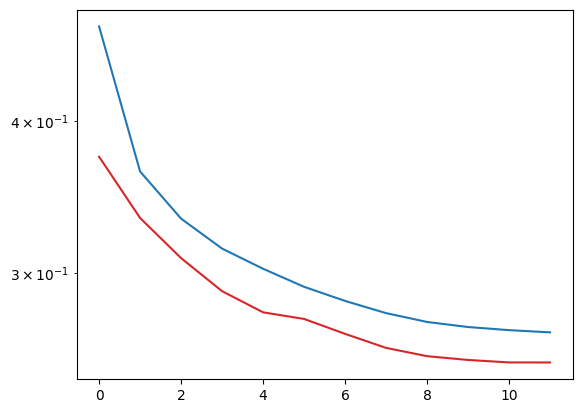

In [18]:
plt.plot(history.history['loss'], color='tab:blue')
plt.plot(history.history['val_loss'], color='tab:red')
plt.yscale('log');

In [19]:
y_valid = np.concatenate([yb for _, yb in ds_valid])
p_valid = model.predict(ds_valid, batch_size=BATCH_SIZE) * stdd_y + mean_y

2024-06-14 05:38:23.216332: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 236ms/step


2024-06-14 05:38:29.596372: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [22]:
p_valid.numpy()[0]

array([ 4.43602936e-05,  1.46943131e-05,  4.88305225e-05,  1.12017648e-04,
        1.02139534e-04,  1.48476938e-04,  1.28295531e-04,  1.09980766e-04,
        6.77336526e-05,  5.09136354e-05,  3.77822329e-05,  3.01005503e-05,
        2.32349838e-05,  1.87771170e-05,  1.29645279e-05,  8.63948773e-06,
        4.81879008e-06,  4.79732978e-06, -2.27718003e-06,  2.51503931e-06,
        1.88472637e-06, -1.27684880e-07,  7.28742310e-07,  5.10689741e-06,
        1.29047397e-05,  1.98162238e-05,  1.52304567e-05, -2.02140169e-06,
        7.45725039e-07,  1.93714738e-07, -3.44355754e-06, -6.67604195e-06,
       -5.15772525e-06, -7.03475992e-06, -1.20278543e-05,  6.09540875e-05,
        9.70713539e-05,  8.30128282e-05,  8.20163398e-05,  7.85220932e-05,
        1.70557049e-05,  3.06791883e-06, -1.79679316e-05, -2.53861159e-05,
       -3.68971560e-05, -4.43181952e-05, -4.01860572e-05, -2.39570120e-05,
       -1.27799796e-05, -1.67825108e-05, -2.68579965e-05, -2.78997596e-05,
       -3.31217081e-05, -

In [20]:
scores_valid = np.array([metrics.r2_score(y_valid[:, i], p_valid[:, i]) for i in range(len(TARGETS))])
plt.plot(scores_valid.clip(-1, 1))

ValueError: Input arrays use different devices: cpu, /job:localhost/replica:0/task:0/device:CPU:0

In [ ]:
mask = scores_valid <= 1e-3
f"Number of under-performing targets: {sum(mask)}"

In [ ]:
f"Clipped score: {scores_valid.clip(0, 1).mean()}"

In [ ]:
del y_valid, p_valid
gc.collect();

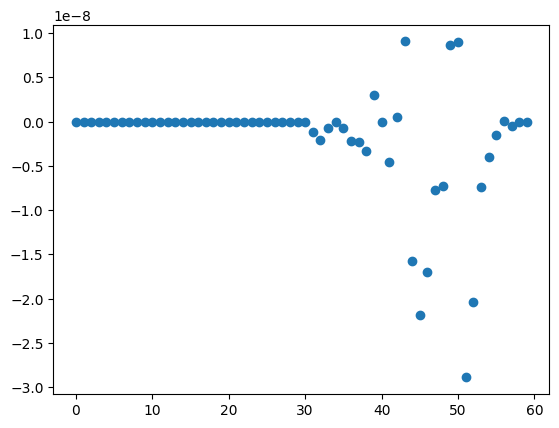

In [14]:
import numpy as np
import matplotlib.pyplot as plt

data = np.load('data/split_90.npy', allow_pickle=True)
plt.scatter(range(60), data[90][-368+120:-368+180])